# Performance Portable Solid Mechanics via Matrix-Free $p$-Multigrid
## Alt title: Constants Matter

## **Jed Brown**, CU Boulder
### Valeria Barra, Natalie Beams, Leila Ghaffari, Matthew Knepley, William Moses, Rezgar Shakeri, Karen Stengel, Jeremy L. Thompson, Junchao Zhang


## 2022-05-13

In [2]:
from IPython.display import SVG, Video, HTML, IFrame
import pandas as pd
import altair as alt
from io import StringIO
import numpy as np


# Nonlinear solid mechanics

<video src="figures/ratel/schwarz-q2-5x5x5-t20-l2-r2.ogv" width="90%" autoplay controls loop />

## Industrial state of practice

* Low order finite elements: $Q_1$ (trilinear) hexahedra, $P_2$ (quadratic) tetrahedra.
* Assembled matrices, sparse direct and algebraic multigrid solvers

## Myths

* High order doesn't help because real problems have singularities.
* Matrix-free methods are just for high order problems

# Industrial models are riddled with singularities

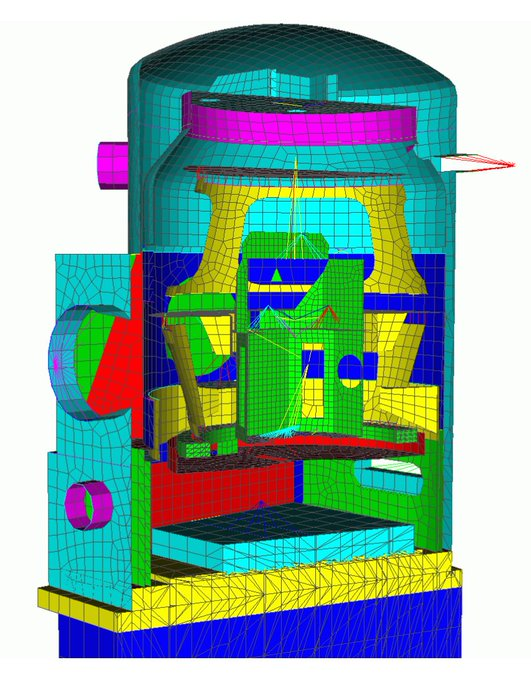

* Every reentrant corner
* Every Dirichlet (fixed/clamped) to Neumann boundary transitien


(From Bhardwaj et al, 2002.)

# Noether: 2x EPYC 7452 with Radeon VII (\$550 in late 2019)

<img src="figures/hardware/noether-nps4-smt.svg" width="100%" />

# The mathematician's way: $hp$ adaptive finite elements

Elliptic PDE always have singularities at reentrant corners (and Dirichlet to Neumann boundary transitions).

<img src="https://www.dealii.org/images/steps/developer/step-27-solution.png" width="80%" />

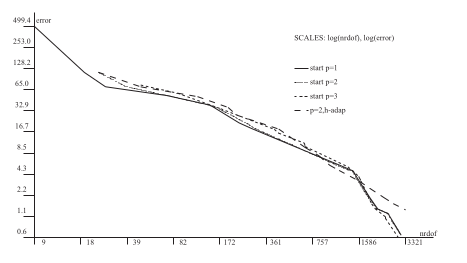
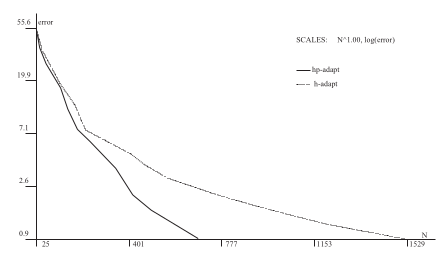

# How does it work?

High order to resolve when solution is smooth, tiny low-order elements near singularities.

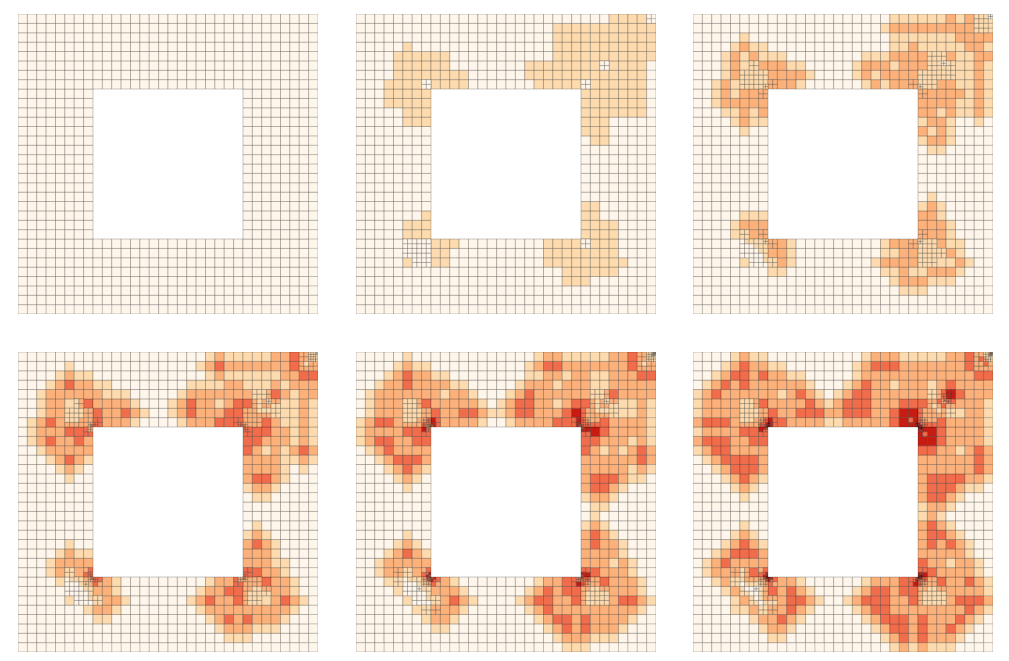

([source: Deal.II step 27](https://dealii.org/developer/doxygen/deal.II/step_27.html))

# What meshes do engineers use?

<img src="https://images.ansys.com/is/image/ansys/fundamentals-of-fea-meshing-cages-motorcycle-pump?&wid=866&op_usm=0.9,1.0,20,0&fit=constrain,0" width="100%" />

[source: Ansys blog](https://www.ansys.com/blog/fundamentals-of-fea-meshing-for-structural-analysis)

<video src="figures/ratel/one-hole-traction-20220222.ogv" autoplay controls loop />

# Approximation constants are good for high order

<img src="figures/ratel/accuracy_study_annotated.svg" width="85%" />

# Spurious stress singularities

<img src="figures/ratel/refinement_mesh.png" width="100%" />

* Geometric model has a round cylinder, no singularity
* Linear meshes have weak reentrant corners
* Moving to quadratic geometry elements is generally good enough
* Gmsh supports arbitrary order

<video src="figures/ratel/one-hole-traction-20220222.ogv" autoplay controls loop />

# Why matrix-free?

* Assembled matrices need at least 4 bytes transferred per flop. Hardware does 10 flops per byte.
* Matrix-free methods store and move less data, compute faster.

<img src="figures/karlrupp/flop-per-byte-dp-2021.svg" class="floatleft" />
<img src="figures/TensorVsAssembly-qstore.svg" class="floatright" />

# Matrix-free is faster for $Q_1$ elements

<img src="figures/ratel/schwarz-apply.svg" width="100%" />

# $p$-multigrid algorithm and cost breakdown

<img src="figures/ratel/p-mg-cycle.png" width="80%" />

<img src="figures/ratel/op_schematic.svg" width="80%" />

In [3]:
IFrame("figures/ratel/schwarz-q2-flame.svg", width="2000", height="350")

# Nonlinear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-SNESSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-SNESSolve.svg" />

# Linear solve efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-KSPSolve.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-KSPSolve.svg" />

* Coarse solver is hypre BoomerAMG tuned configured for elasticity; thanks Victor Paludetto
Magri.

# Preconditioner setup efficiency

## $Q_2$ elements
<img src="figures/ratel/schwarz-q2-t20-r2-l2-PCSetUp.svg" />

## $Q_3$ elements
<img src="figures/ratel/schwarz-q3-t20-r2-l1-PCSetUp.svg" />

# One node of Crusher vs historical Gordon Bell
## 184 MDoF $Q_2$ elements nonlinear analysis in seconds

## 2002 Gordon Bell (Bhardwaj et al)

<img src="figures/ratel/gordon-bell-2002-mems.png" width="70%" />

<img src="figures/ratel/gordon-bell-2002-mems-table.png" width="100%" />

## 2004 Gordon Bell (Adams et al)

<img src="figures/ratel/gordon-bell-2004-bone.png" width="70%" />

<img src="figures/ratel/gordon-bell-2004-bone-scaling.jpg" width="100%" />

## [libCEED](https://libceed.readthedocs.io): fast algebra for finite elements

* Backend plugins with run-time selection
  * debug/memcheck, optimized
  * libxsmm, CUDA, HIP
  * MAGMA to CUDA and HIP
  * OCCA to OpenMP, OpenCL, CUDA, and HIP
* Single source vanilla C for QFunctions
  * Easy to debug, understand locally, C++ optional
  * Target for DSLs, AD
* Python, Julia, Rust
* 2-clause BSD
* Available via MFEM, PETSc, Nek5000

<img src="figures/ceed/libceed-backends-tex.png" />

Thanks to many developers, including Jeremy Thompson, Yohann Dudouit, Valeria Barra, Natalie Beams,  Ahmad Abdelfattah, Leila Ghaffari, Will Pazner, Thilina Ratnayaka, Tzanio Kolev, Veselin Dobrev, David Medina

<img src="figures/ceed/libCEED-2.png" width=100% />


## Quadrature functions: the math

\begin{gather*}
    v^T F(u) \sim \int_\Omega v \cdot \color{olive}{f_0(u, \nabla u)} + \nabla v \!:\! \color{olive}{f_1(u, \nabla u)} \quad
    v^T J w \sim \int_\Omega \begin{bmatrix} v \\ \nabla v \end{bmatrix}^T \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}}
    \begin{bmatrix} w \\ \nabla w \end{bmatrix} \\
    u = B_I \mathcal E_e u_L \qquad \nabla u = \frac{\partial X}{\partial x} B_{\nabla} \mathcal E_e u_L \\
    J w = \sum_e \mathcal E_e^T \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix}^T
    \underbrace{\begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right)^T \end{bmatrix} W_q \color{teal}{\begin{bmatrix} f_{0,0} & f_{0,1} \\ f_{1,0} & f_{1,1} \end{bmatrix}} \begin{bmatrix} I & \\ & \left( \frac{\partial X}{\partial x}\right) \end{bmatrix}}_{\text{coefficients at quadrature points}} \begin{bmatrix} B_I \\ B_{\nabla} \end{bmatrix} \mathcal E_e w_L
\end{gather*}
  
* $B_I$ and $B_\nabla$ are tensor contractions -- independent of element geometry
* Choice of how to order and represent gathers $\mathcal E$ and scatters $\mathcal E^T$
* Similar for Neumann/Robin and nonlinear boundary conditions

## Quadrature functions: debuggable, vectorizable, and JITable

* Independent operations at each of `Q` quadrature points, order unspecified

```c
int L2residual(void *ctx, CeedInt Q,
    const CeedScalar *const in[],
    CeedScalar *const out[]) {
  const CeedScalar *u = in[0], *rho = in[1], *target = in[2];
  CeedScalar *v = out[0];
  for (CeedInt i=0; i<Q; i++)
    v[i] = rho[i] * (u[i] - target[i]);
  return 0;
}
```

![](figures/ceed/solids-perf-disassembly.png)

# Vector hand-off

```c
  DMGlobalToLocal(ctx->dm_x, X, INSERT_VALUES, ctx->X_loc);

  // Setup libCEED vectors
  VecGetArrayReadAndMemType(ctx->X_loc, &x, &x_mem_type);
  VecGetArrayAndMemType(ctx->Y_loc, &y, &y_mem_type);
  CeedVectorSetArray(ctx->x_loc_ceed, P2C(x_mem_type), CEED_USE_POINTER, x);
  CeedVectorSetArray(ctx->y_loc_ceed, P2C(y_mem_type), CEED_USE_POINTER, y);

  // Apply libCEED operator
  CeedOperatorApply(ctx->op, ctx->x_loc_ceed, ctx->y_loc_ceed, CEED_REQUEST_IMMEDIATE);

  // Restore PETSc vectors
  CeedVectorTakeArray(ctx->x_loc_ceed, P2C(x_mem_type), NULL);
  CeedVectorTakeArray(ctx->y_loc_ceed, P2C(y_mem_type), NULL);
  VecRestoreArrayReadAndMemType(ctx->X_loc, &x);
  VecRestoreArrayAndMemType(ctx->Y_loc, &y);

  DMLocalToGlobal(ctx->dm_y, ctx->Y_loc, ADD_VALUES, Y);
```

# Matrix assembly

## Symbolic: once for matrix structure
```c
PetscInt *rows, *cols;
CeedOperatorLinearAssembleSymbolic(op_ceed, &num_entries, &rows, &cols);
MatSetPreallocationCOOLocal(A, num_entries, rows, cols);
free(rows);
free(cols);
```

## Numeric
```c
CeedVector values_ceed;
PetscScalar *values;

CeedOperatorLinearAssemble(op_ceed, coo_values_ceed);
CeedVectorGetArrayRead(coo_values_ceed, ceed_memory_space, &values);
MatSetValuesCOO(A, values, INSERT_VALUES);
```

# libCEED and PETSc asynchrony

![](figures/ceed/libceed-bp3-nsys-cuda-gen.png)

# libCEED solid mechanics flame graphs

In [4]:
IFrame("data/ceed/noether/noether-solids-holes-P4-xsmm-coo.svg", width="1600", height="900")

# Solids: efficient matrix-free Jacobians
## cf. [Davydov et al. (2020)](https://doi.org/10.1002/nme.6336)

<img src="figures/ceed/libceed-solids-initial-current.png" width="80%" />
<img src="figures/ceed/libceed-solids-jacobian-table.png" width="80%" />

# Outlook: https://ratel.micromorph.org

* You can move from $Q_1$ to $Q_2$ elements for about 2x cost (despite 8x more DoFs)
* Mesh to resolve geometry, $p$-refine to pragmatic accuracy
* libCEED isn't just for high order; already 2x operator apply benefit for $Q_1$
* Gordon Bell scale from 20 years ago $\mapsto$ interactive on a workstation (if you can buy MI250X 😊)
* $p$-multigrid, low-memory representation of matrix-free Jacobian
* Multi-node GPU on CUDA and ROCm
* Also good for implicit dynamics

<video src="figures/ratel/schwarz-pendulum.mkv" autoplay loop controls width="100%" />

<img src="figures/micromorph/libceed-epoxy-traction-20210829.gif" width="80%" />